<a href="https://colab.research.google.com/github/pscabral/IFMA_Softex/blob/main/InceptionV3_1.00_160.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.optimizers import Adam
# list paths of train and test datasets
os.listdir('/content/fruits_v2')

['train', 'test', 'val']

In [29]:
TRAIN_PATH = "/content/fruits_v2/train"
TEST_PATH = "/content/fruits_v2/test"
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001
IMG_SHAPE= (224,224)
## train generator
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                 zoom_range=0.2,
                                 shear_range=0.3,
                                 horizontal_flip=True,
                                 brightness_range=[0.5,1.5])
#test generator
test_datagen = ImageDataGenerator(rescale=1/255.0)

#generate data from train and test directories
train_gen = train_datagen.flow_from_directory(TRAIN_PATH,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="binary")

test_gen = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size=IMG_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="binary")

Found 11787 images belonging to 33 classes.
Found 1706 images belonging to 33 classes.


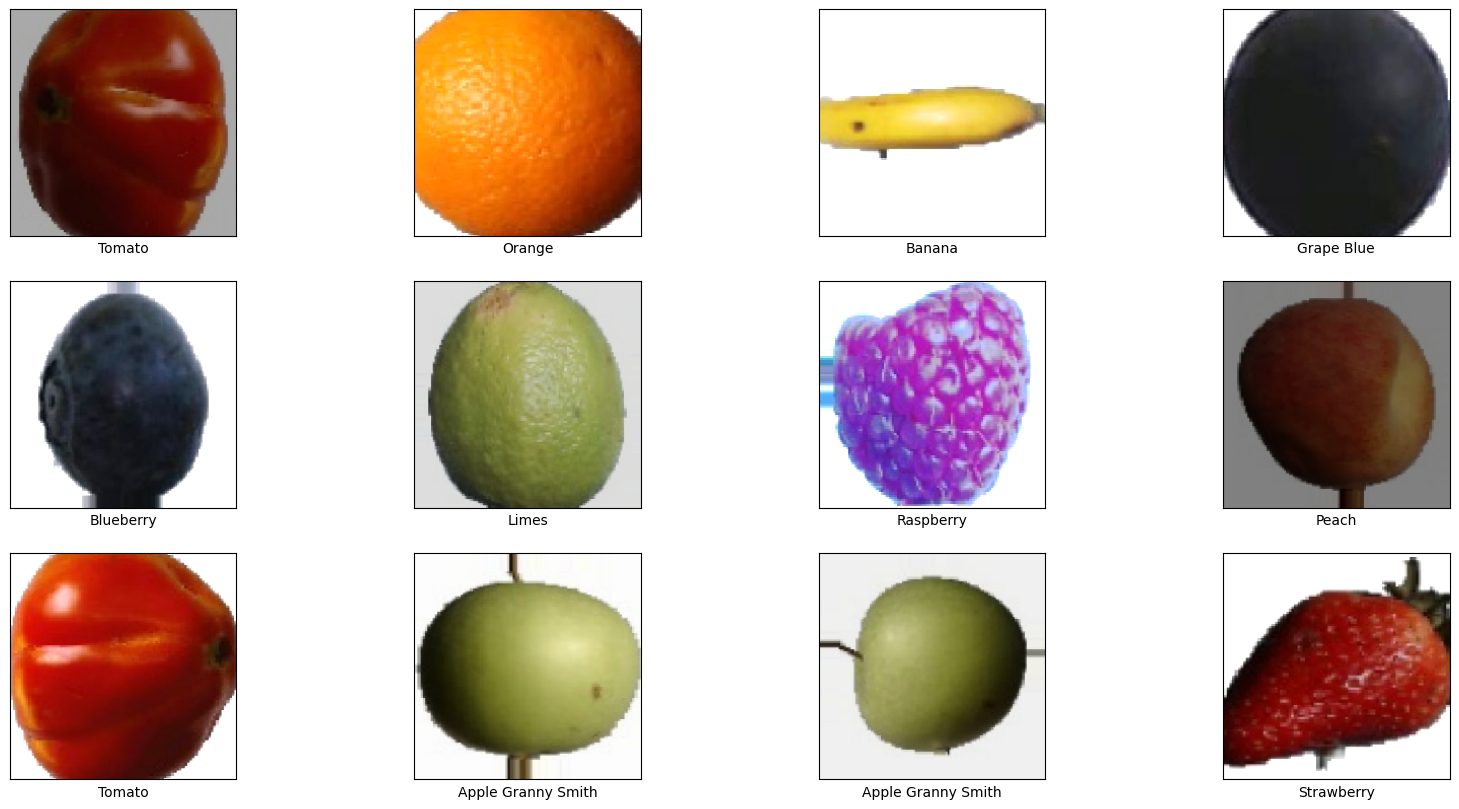

In [30]:
#get classes dict
classes_dict = dict(test_gen.class_indices)
#reverse
classes_dict = {v: k for k,v in classes_dict.items()}
#let's plot sone images
images,labels=train_gen.next()
plt.figure(figsize=(20,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes_dict[labels[i]])

In [31]:
#create Inception Model
inception = InceptionV3(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
#show the base model summary
inception.summary()
#show how manay layers in the Resnet Network
layers = inception.layers
print(f'Number of Layers: {len(layers)}')

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_470 (Conv2D)         (None, 111, 111, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_470 (B  (None, 111, 111, 32)         96        ['conv2d_470[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_470 (Activation  (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
# Número de amostras em cada conjunto de dados
TRAIN_SIZE = 11787
TEST_SIZE = 1706

# Parada antecipada
callbacks = EarlyStopping(patience=3, monitor='val_acc')

# Crie o modelo base Inception
inputs = inception.input
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(33, activation='softmax')(x)

# Crie o modelo completo
model = Model(inputs=inputs, outputs=outputs)

# Congele todas as camadas de convolução do Inception
for layer in inception.layers:
    layer.trainable = False

# Compile o modelo com o otimizador Adam usando 'learning_rate' em vez de 'lr'
model.compile(optimizer=Adam(learning_rate=0.001),  # Substitua 0.001 pela taxa de aprendizado desejada
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treine o modelo usando 'model.fit'
history = model.fit(
    train_gen,
    epochs=5,  # Ajuste o número de épocas conforme necessário
    validation_data=test_gen,
    steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
    validation_steps=TEST_SIZE // BATCH_SIZE,
    callbacks=[callbacks]
)


Epoch 1/5
 33/368 [=>............................] - ETA: 25:11 - loss: 2.0347 - accuracy: 0.4628

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Text(0.5, 0, 'N.of Epochs')

<Figure size 640x480 with 0 Axes>

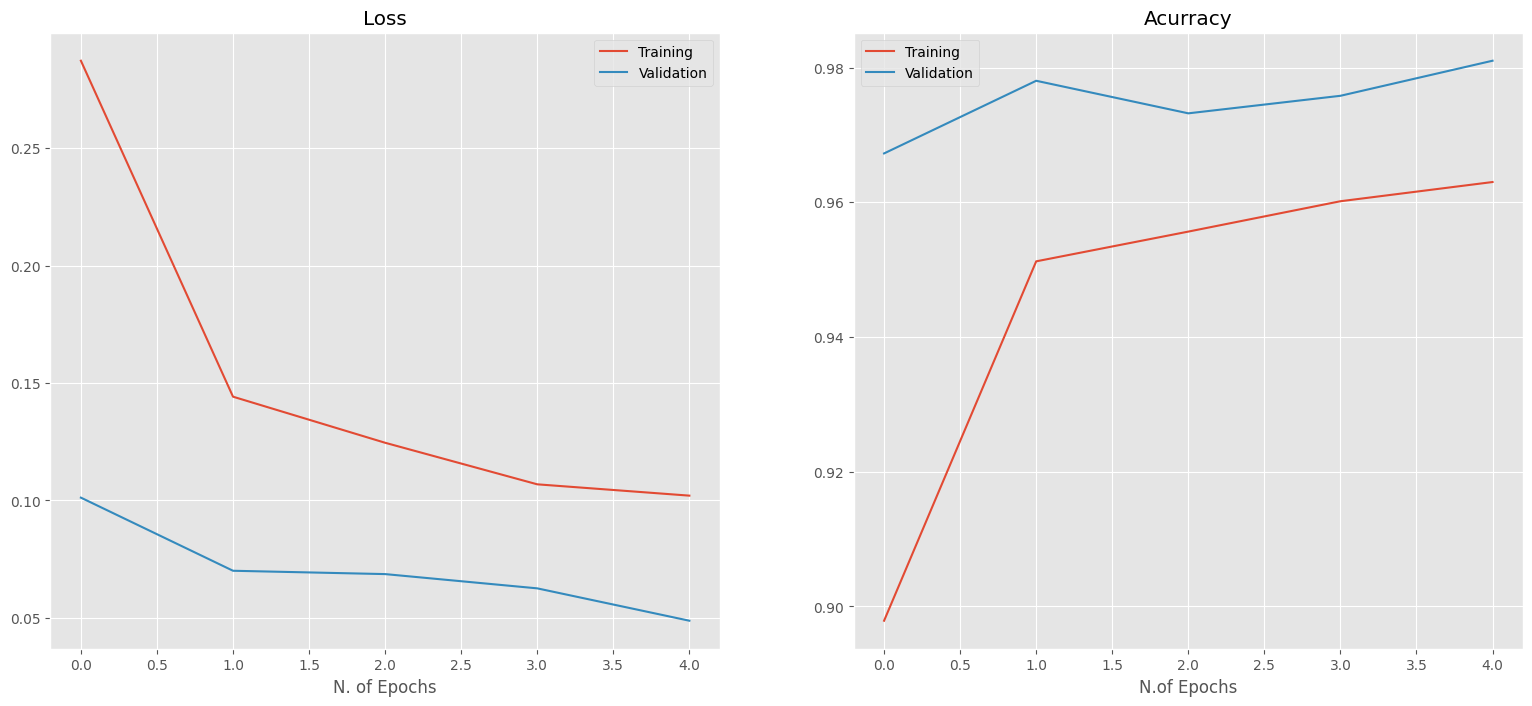

In [7]:
# Plot training loss vs validation loss
plt.style.use('ggplot')
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,8))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'])
ax1.set_title('Loss')
ax1.set_xlabel('N. of Epochs')
## plot training accuracy vs validation accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('N.of Epochs')

In [8]:
#Evaluate
loss, test_acc = model.evaluate(test_gen)
print("Validation Accuracy = %f \nValidation Loss = %f " % (test_acc, loss))

85/85 [==============================] - 341s 4s/step - loss: 0.0492 - accuracy: 0.9807
Validation Accuracy = 0.980726 
Validation Loss = 0.049170 


85/85 [==============================] - 326s 4s/step


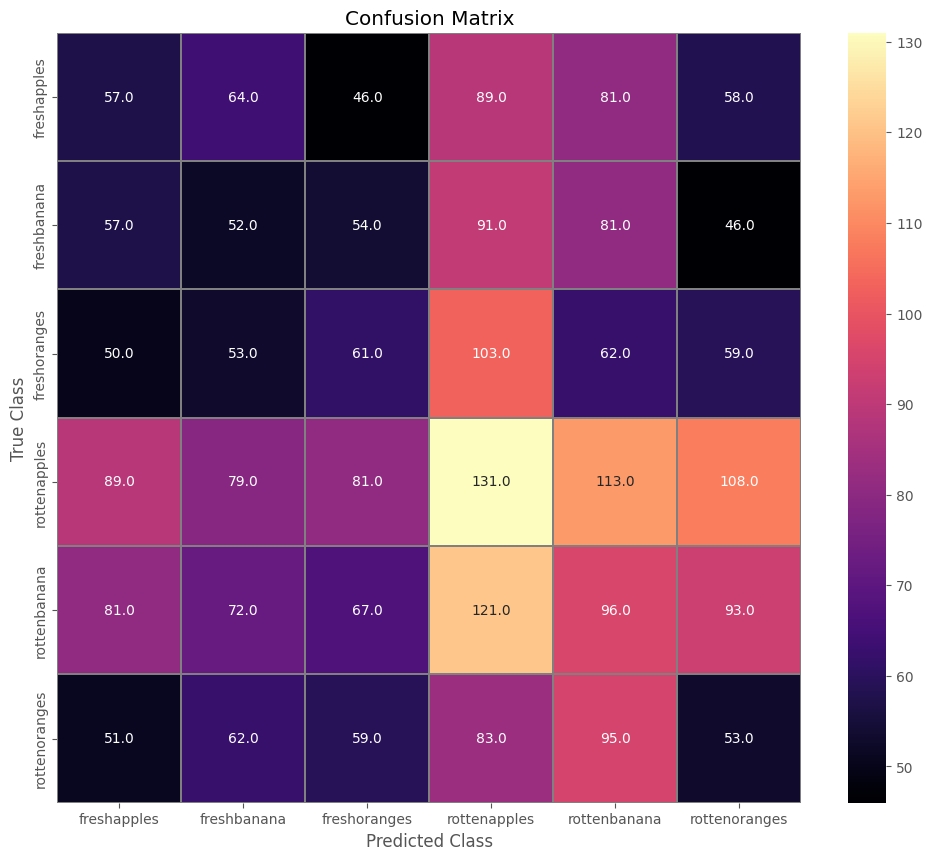

In [9]:
class_names = list(classes_dict.values())
labels = test_gen.classes
preds =  model.predict(test_gen)
predictions = np.argmax(preds, axis=1)
#show the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
# plot the confusion matrix
fig,ax = plt.subplots(figsize=(12, 10))
sb.heatmap(conf_matrix, annot=True, linewidths=0.01,cmap="magma",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
ax.set_xticklabels(labels = class_names,fontdict=None)
ax.set_yticklabels(labels = class_names,fontdict=None)
plt.show()

1/1 [==============================] - 0s 145ms/step


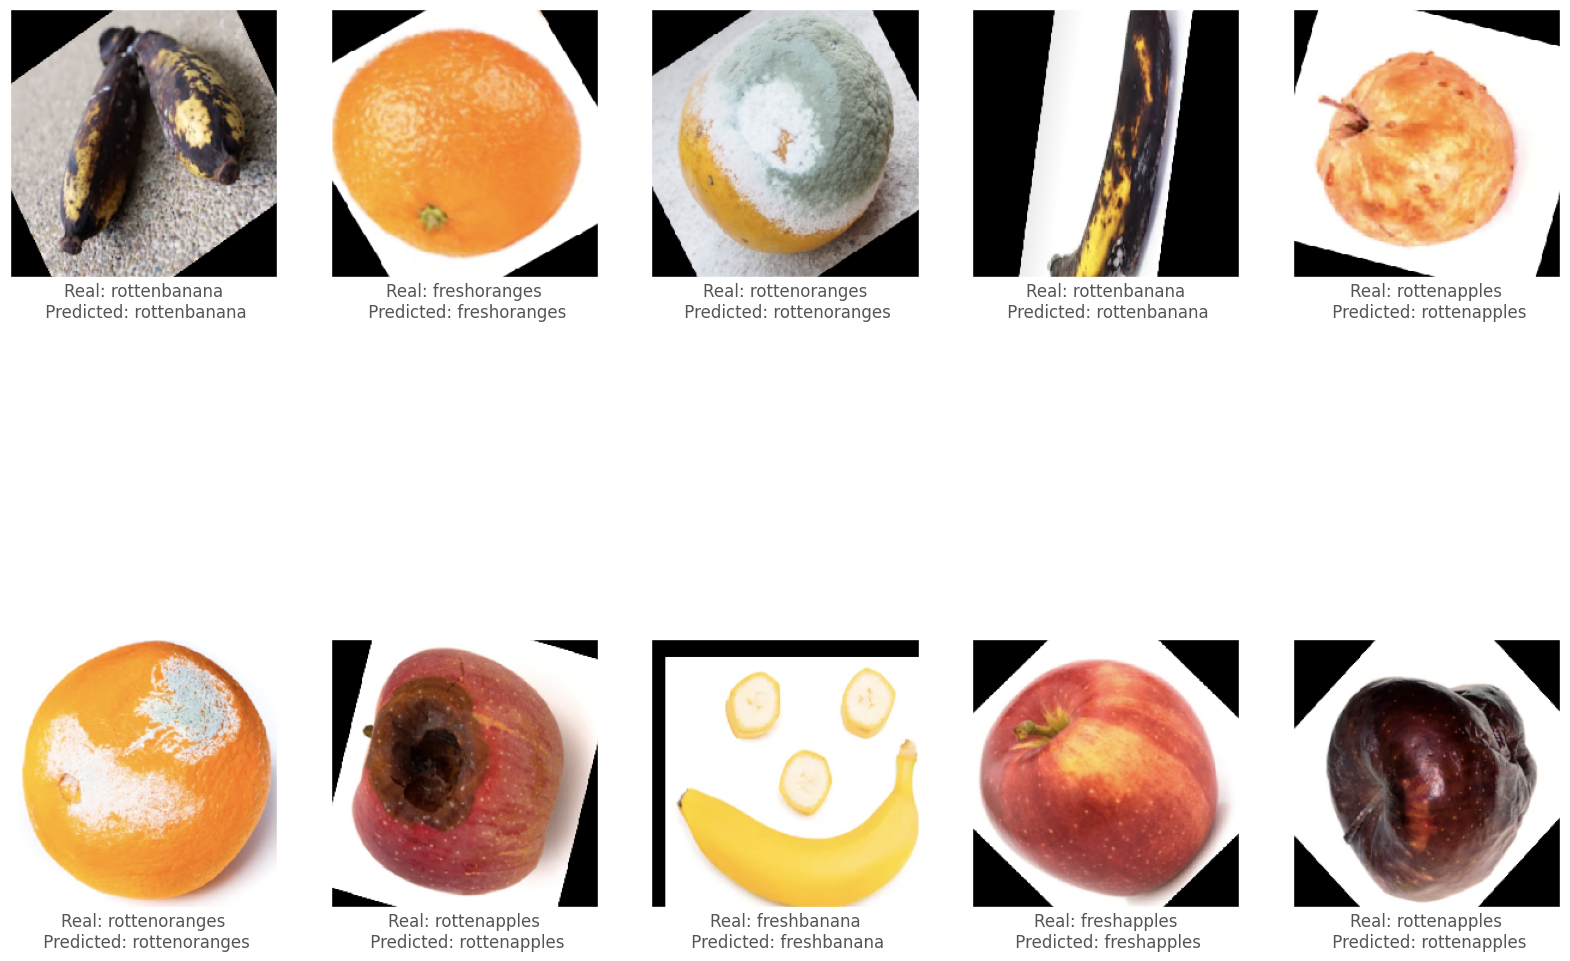

In [10]:
test_images,test_labels=test_gen.next()
plt.figure(figsize=(20,15))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_images[i])
    plt.xticks([])
    plt.yticks([])
    real = classes_dict[test_labels[i]]
    img = test_images[i].reshape(1,224,224,3)
    predicted = int(np.argmax(model.predict(img),axis=1))
    predicted = classes_dict[predicted]
    plt.xlabel(f"Real: {real}\n Predicted: {predicted}")

In [11]:
# Salve o modelo em um arquivo HDF5
model.save('modelo_inceptionv3_frutas.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
#!pip install gTTS
import cv2
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow
from gtts import gTTS
import IPython.display as ipd

# Caminho para a imagem de teste
caminho_imagem_teste = '/content/fruits-fresh-rotten-classification/upload test/fresh-fruit.jpeg'  # Substitua pelo caminho da sua imagem de teste

# Ler a imagem de teste
image = cv2.imread(caminho_imagem_teste)

# Redimensionar a imagem para o tamanho esperado pelo InceptionV3
image_resized = cv2.resize(image, (299, 299))

# Adicionar a dimensão do lote (batch)
image_resized = np.expand_dims(image_resized, axis=0)

# Pré-processamento específico do InceptionV3
image_preprocessed = preprocess_input(image_resized)

# Carregar o modelo InceptionV3
model = InceptionV3(weights='imagenet')

# Fazer a previsão usando o modelo InceptionV3
predicted_label = model.predict(image_preprocessed)

# Decodificar o rótulo previsto para obter as principais previsões
predicted_labels = decode_predictions(predicted_label, top=3)[0]

# Exibir as previsões
for i, (imagenet_id, label, score) in enumerate(predicted_labels):
    print(f"Previsão {i + 1}: {label} ({score:.2f})")

# Gerar o arquivo de áudio com o nome do produto previsto
predicted_class = predicted_labels[0][1]  # Usando a previsão principal
tts = gTTS(text=f'O produto é {predicted_class}', lang='pt')
tts.save('/content/prevision.mp3')

# Reproduzir o arquivo de áudio
ipd.Audio('/content/prevision.mp3')


1/1 [==============================] - 2s 2s/step
Previsão 1: pomegranate (0.23)
Previsão 2: fig (0.10)
Previsão 3: acorn (0.05)
